# import files

In [ ]:
import os
from google.colab import files
import pandas as pd
import numpy as np
import string
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


# inpoot banfake dataset


In [ ]:
# Upload kaggle.json if needed
if not os.path.exists('kaggle.json'):
    print("Please upload your kaggle.json file:")
    uploaded = files.upload()
else:
    print("kaggle.json already exists. Skipping upload.")

# Install packages
!pip install -q kaggle xgboost lightgbm imbalanced-learn

# Kaggle CLI setup
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d hrithikmajumdar/bangla-fake-news
!unzip -o bangla-fake-news.zip -d ./banfake-news

!ls ./banfake-news/

Please upload your kaggle.json file:


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/hrithikmajumdar/bangla-fake-news
License(s): apache-2.0
 82% 53.0M/64.4M [00:00<00:00, 518MB/s]
100% 64.4M/64.4M [00:00<00:00, 395MB/s]
Archive:  bangla-fake-news.zip
  inflating: ./banfake-news/test_cleaned.csv  
  inflating: ./banfake-news/train_cleaned.csv  
  inflating: ./banfake-news/val_cleaned.csv  
test_cleaned.csv  train_cleaned.csv  val_cleaned.csv


lode banfake dataset

In [ ]:
# Load datasets
train_df = pd.read_csv('/content/banfake-news/train_cleaned.csv')
test_df = pd.read_csv('/content/banfake-news/test_cleaned.csv')
validation_df = pd.read_csv('/content/banfake-news/val_cleaned.csv')

take Fake (0) -> 0, Real (3) -> 1

In [ ]:
label_column = 'Label'

# Combine all data
df_all = pd.concat([train_df, test_df, validation_df], ignore_index=True)

# Binary label mapping: Fake (0) -> 0, Real (3) -> 1
real_df = df_all[df_all['Label'] == 3].copy()
fake_df = df_all[df_all['Label'] == 0].copy()

real_df['Label'] = 1
fake_df['Label'] = 0

In [ ]:
real_df['text'] = real_df['Headline'].fillna('') + ' ' + real_df['Content'].fillna('')
real_df['text'] = real_df['text'].astype(str).str.lower().str.translate(str.maketrans('', '', string.punctuation))

fake_df['text'] = fake_df['Headline'].fillna('') + ' ' + fake_df['Content'].fillna('')
fake_df['text'] = fake_df['text'].astype(str).str.lower().str.translate(str.maketrans('', '', string.punctuation))

# lode bangla_fake500 dataset

In [ ]:
!kaggle datasets download -d zihadbappy/banglafakenews500
!mkdir -p ./bangla_fake500
!unzip -o banglafakenews500.zip -d ./bangla_fake500

# Install openpyxl
!pip install openpyxl

# Load Excel and clean
df500 = pd.read_excel('./bangla_fake500/BanglaFakeNews500.xlsx')
df500['text'] = df500['headline'].fillna('') + ' ' + df500['Content'].fillna('')
df500['text'] = df500['text'].astype(str).str.lower().str.translate(str.maketrans('', '', string.punctuation))
df500['label'] = 0

df500 = df500[['text', 'label']]

Dataset URL: https://www.kaggle.com/datasets/zihadbappy/banglafakenews500
License(s): CC0-1.0
  0% 0.00/682k [00:00<?, ?B/s]
100% 682k/682k [00:00<00:00, 542MB/s]
Archive:  banglafakenews500.zip
  inflating: ./bangla_fake500/BanglaFakeNews500.xlsx  


# marge buth dataset

In [ ]:
import pandas as pd
# Rename 'label' column in df500 to match 'Label' in fake_df
df500.rename(columns={'label': 'Label'}, inplace=True)

# Concatenate fake_df and df500
fake_df = pd.concat([fake_df, df500], ignore_index=True)

print(f"Number of fake news articles after adding df500: {len(fake_df)}")

Number of fake news articles after adding df500: 2682


/tmp/ipython-input-12-3464124454.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df500.rename(columns={'label': 'Label'}, inplace=True)


In [ ]:
if len(real_df) > 2682:
    real_df = real_df.sample(n=2682, random_state=42).reset_index(drop=True)

print(f"Final number of real news articles: {len(real_df)}")

Final number of real news articles: 2682


In [ ]:
import pandas as pd
# Concatenate real_df and fake_df into All_df
All_df = pd.concat([real_df, fake_df], ignore_index=True)

print(f"Total number of articles in All_df: {len(All_df)}")
print(All_df['Label'].value_counts())

Total number of articles in All_df: 5364
Label
1    2682
0    2682
Name: count, dtype: int64


In [ ]:
# prompt: show the dize of All_df

print(f"Size of All_df: {All_df.shape}")
All_df.head()

Size of All_df: (5364, 4)


,Headline,Content,Label,text
0,পলাতকরা কে কোথায়,ভয়াবহ ২১ আগস্ট গ্রেনেড হামলার মামলায় পলাতক ১৮ ...,1,পলাতকরা কে কোথায় ভয়াবহ ২১ আগস্ট গ্রেনেড হামলার...
1,ইসরাইলি বিমান হামলা সিরিয়ার সার্বভৌমত্বের লঙ্ঘ...,আন্তর্জাতিক ডেস্ক আরটিএনএন মস্কো: রাশিয়ার প্রে...,1,ইসরাইলি বিমান হামলা সিরিয়ার সার্বভৌমত্বের লঙ্ঘ...
2,"ঢাবিতে বিক্ষোভ সমাবেশ, আদিবাসী কোটা ৫ শতাংশ রা...",দ্য রিপোর্ট ডেস্ক : সরকারি চাকরিতে প্রথম ও দ্ব...,1,ঢাবিতে বিক্ষোভ সমাবেশ আদিবাসী কোটা ৫ শতাংশ রাখ...
3,এবারও সেরাদের সেরা রাজশাহীর মেয়েরা,বিতর্ক উৎসবে শ্রেষ্ঠত্ব অর্জন করল রাজশাহী শহরে...,1,এবারও সেরাদের সেরা রাজশাহীর মেয়েরা বিতর্ক উৎসব...
4,জাতীয় ঐক্য’র যৌথ নেতৃত্বে বদরুদ্দোজা-কামাল-ফখরুল,নিজস্ব প্রতিবেদক আরটিএনএন ঢাকা: জাতীয় ঐক্যকে এ...,1,জাতীয় ঐক্য’র যৌথ নেতৃত্বে বদরুদ্দোজাকামালফখরুল...


In [ ]:
import pandas as pd
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
tfidf_matrix = tfidf_vectorizer.fit_transform(All_df['text'])

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

all_df = pd.concat([tfidf_df, All_df['Label']], axis=1)


In [ ]:
X = all_df.drop('Label', axis=1)
y = all_df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

SVM Accuracy: 0.9002795899347623
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       537
           1       0.89      0.91      0.90       536

    accuracy                           0.90      1073
   macro avg       0.90      0.90      0.90      1073
weighted avg       0.90      0.90      0.90      1073



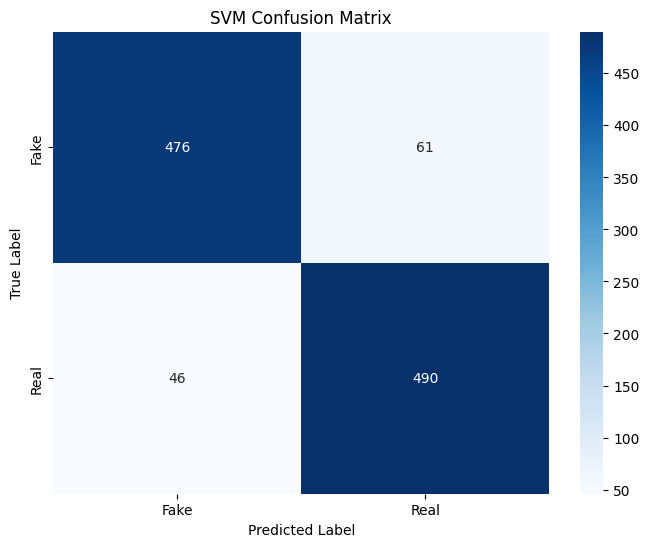

In [ ]:
# prompt: train SVM

import matplotlib.pyplot as plt
# Train a Linear SVM model
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_svm = svm_model.predict(X_test)

# Evaluate the model
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

print(f"SVM Accuracy: {accuracy_svm}")
print("SVM Classification Report:")
print(report_svm)


# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Logistic Regression Model Evaluation:
Accuracy: 0.9040074557315937
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.89      0.90       537
           1       0.89      0.92      0.91       536

    accuracy                           0.90      1073
   macro avg       0.90      0.90      0.90      1073
weighted avg       0.90      0.90      0.90      1073



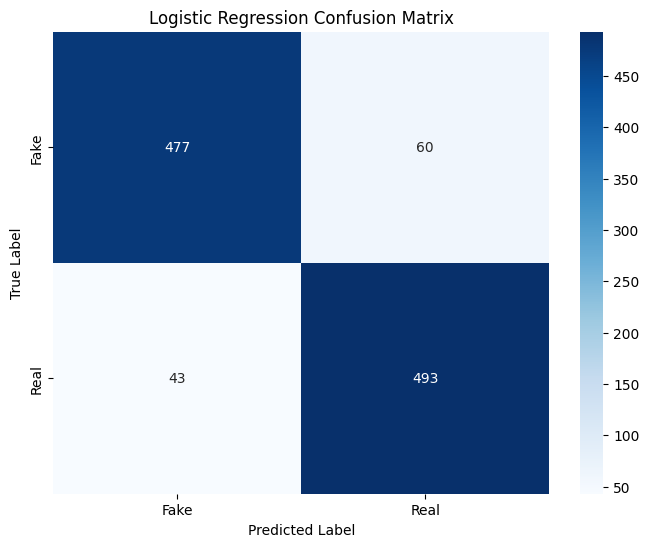

In [ ]:
# prompt: Train Logistic Regression

import matplotlib.pyplot as plt
# Train a Logistic Regression model
log_reg_model = LogisticRegression(random_state=42)
log_reg_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_log_reg = log_reg_model.predict(X_test)

# Evaluate the model
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
report_log_reg = classification_report(y_test, y_pred_log_reg)
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

# Print evaluation metrics
print("\nLogistic Regression Model Evaluation:")
print(f"Accuracy: {accuracy_log_reg}")
print("Classification Report:")
print(report_log_reg)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_log_reg, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Naive Bayes Model Evaluation:
Accuracy: 0.9114631873252563
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       537
           1       0.89      0.93      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



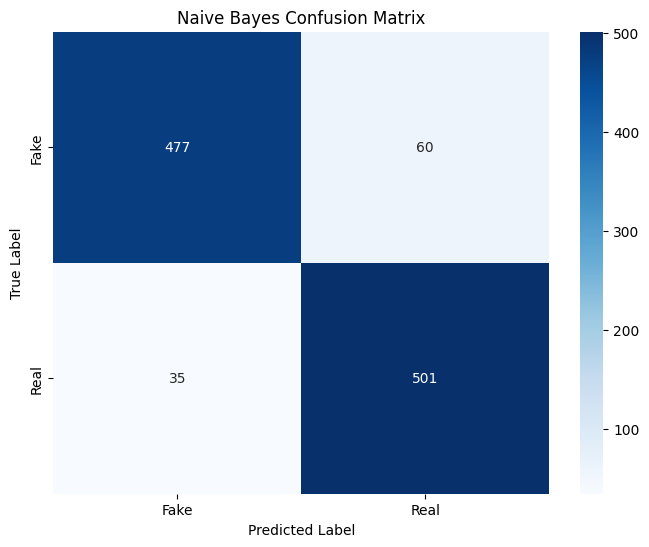

In [ ]:
# prompt: # Train Naive Bayes

import matplotlib.pyplot as plt
# Train a Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_nb = nb_model.predict(X_test)

# Evaluate the model
accuracy_nb = accuracy_score(y_test, y_pred_nb)
report_nb = classification_report(y_test, y_pred_nb)
conf_matrix_nb = confusion_matrix(y_test, y_pred_nb)

# Print evaluation metrics
print("\nNaive Bayes Model Evaluation:")
print(f"Accuracy: {accuracy_nb}")
print("Classification Report:")
print(report_nb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_nb, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Naive Bayes Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


XGBoost Model Evaluation:
Accuracy: 0.9095992544268406
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       537
           1       0.90      0.92      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



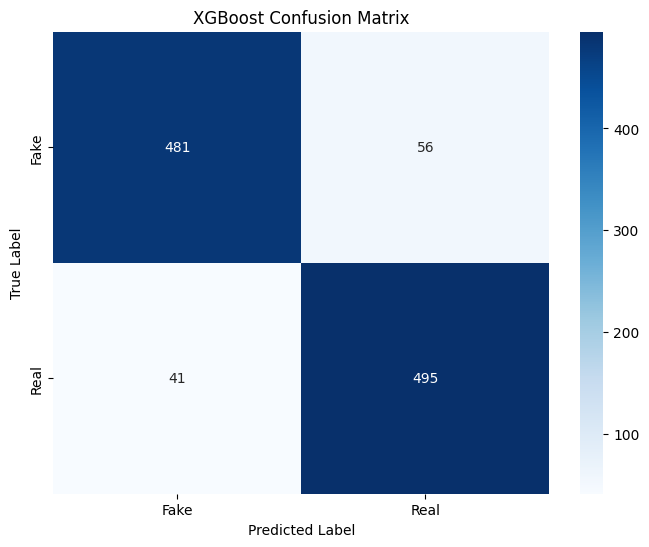

In [ ]:
# Train XGBoost

import matplotlib.pyplot as plt
# Train an XGBoost model
import xgboost as xgb

xgb_model = xgb.XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
report_xgb = classification_report(y_test, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_test, y_pred_xgb)

# Print evaluation metrics
print("\nXGBoost Model Evaluation:")
print(f"Accuracy: {accuracy_xgb}")
print("Classification Report:")
print(report_xgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_xgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


[LightGBM] [Info] Number of positive: 2146, number of negative: 2145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.107910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99750
[LightGBM] [Info] Number of data points in the train set: 4291, number of used features: 1650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500117 -> initscore=0.000466
[LightGBM] [Info] Start training from score 0.000466

LightGBM Model Evaluation:
Accuracy: 0.9114631873252563
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91       537
           1       0.89      0.93      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



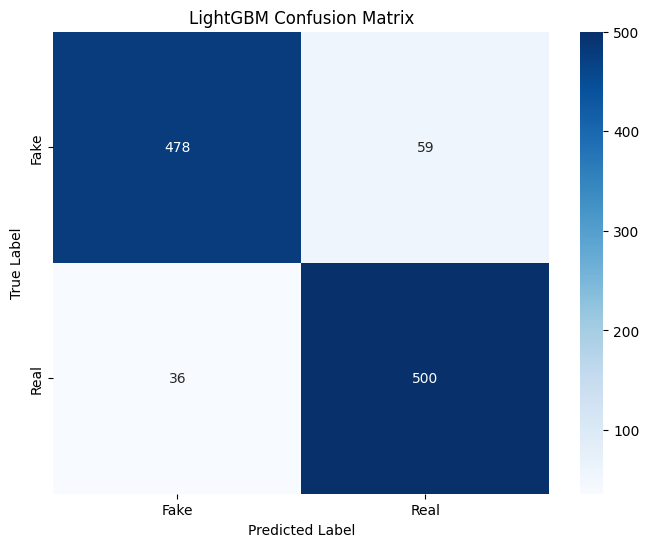

In [ ]:
# prompt: Train LightGBM

import matplotlib.pyplot as plt
import lightgbm as lgb

# Train a LightGBM model
lgb_model = lgb.LGBMClassifier(random_state=42)
lgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgb = lgb_model.predict(X_test)

# Evaluate the model
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
report_lgb = classification_report(y_test, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_test, y_pred_lgb)

# Print evaluation metrics
print("\nLightGBM Model Evaluation:")
print(f"Accuracy: {accuracy_lgb}")
print("Classification Report:")
print(report_lgb)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgb, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

[LightGBM] [Info] Number of positive: 2146, number of negative: 2145
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.104717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 99750
[LightGBM] [Info] Number of data points in the train set: 4291, number of used features: 1650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500117 -> initscore=0.000466
[LightGBM] [Info] Start training from score 0.000466

Ensemble Model Evaluation:
Accuracy: 0.9133271202236719
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.90      0.91       537
           1       0.90      0.93      0.91       536

    accuracy                           0.91      1073
   macro avg       0.91      0.91      0.91      1073
weighted avg       0.91      0.91      0.91      1073



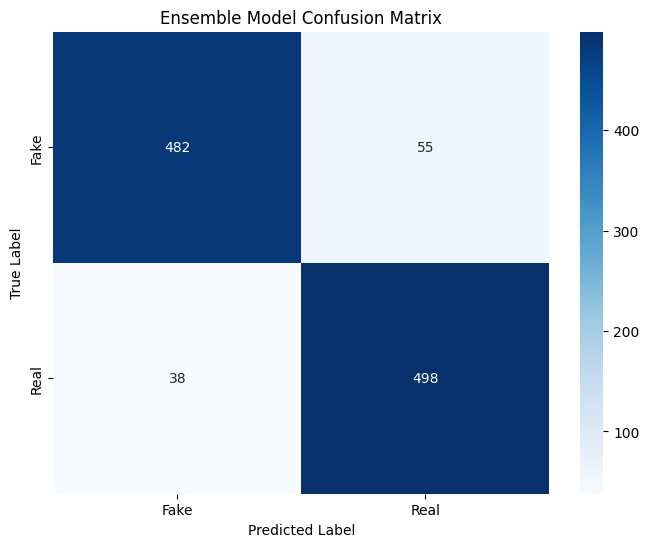

In [ ]:
# prompt: Ensemble with all 5 models

import matplotlib.pyplot as plt
# Create the ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('svm', svm_model),
    ('log_reg', log_reg_model),
    ('nb', nb_model),
    ('xgb', xgb_model),
    ('lgb', lgb_model)
], voting='hard') # 'hard' for majority voting

# Train the ensemble model
ensemble_model.fit(X_train, y_train)

# Make predictions with the ensemble model
y_pred_ensemble = ensemble_model.predict(X_test)

# Evaluate the ensemble model
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)
report_ensemble = classification_report(y_test, y_pred_ensemble)
conf_matrix_ensemble = confusion_matrix(y_test, y_pred_ensemble)

# Print evaluation metrics for the ensemble model
print("\nEnsemble Model Evaluation:")
print(f"Accuracy: {accuracy_ensemble}")
print("Classification Report:")
print(report_ensemble)

# Plot confusion matrix for the ensemble model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Ensemble Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

[LightGBM] [Info] Number of positive: 2146, number of negative: 2145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.129838 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 99750
[LightGBM] [Info] Number of data points in the train set: 4291, number of used features: 1650
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500117 -> initscore=0.000466
[LightGBM] [Info] Start training from score 0.000466

Top 3 Ensemble Model Evaluation (LightGBM, XGBoost, Naive Bayes):
Accuracy: 0.918918918918919
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.90      0.92       537
           1       0.90      0.94      0.92       536

    accuracy                           0.92      1073
   macro avg       0.92      0.92      0.92      1073
weighted avg       0.92      0.92      0.92      1073


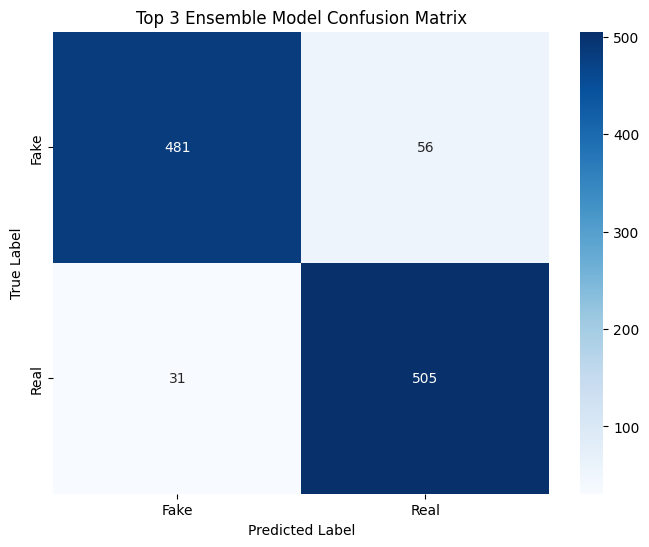

In [ ]:
# prompt: Ensemble with best 3 (assumed LightGBM, XGBoost, Naive Bayes)

import matplotlib.pyplot as plt
# Create the ensemble model using VotingClassifier with the top 3 models (assuming LightGBM, XGBoost, Naive Bayes from previous output/task description)
ensemble_model_top3 = VotingClassifier(estimators=[
    ('lgb', lgb_model),
    ('xgb', xgb_model),
    ('nb', nb_model)
], voting='hard') # 'hard' for majority voting

# Train the top 3 ensemble model
ensemble_model_top3.fit(X_train, y_train)

# Make predictions with the top 3 ensemble model
y_pred_ensemble_top3 = ensemble_model_top3.predict(X_test)

# Evaluate the top 3 ensemble model
accuracy_ensemble_top3 = accuracy_score(y_test, y_pred_ensemble_top3)
report_ensemble_top3 = classification_report(y_test, y_pred_ensemble_top3)
conf_matrix_ensemble_top3 = confusion_matrix(y_test, y_pred_ensemble_top3)

# Print evaluation metrics for the top 3 ensemble model
print("\nTop 3 Ensemble Model Evaluation (LightGBM, XGBoost, Naive Bayes):")
print(f"Accuracy: {accuracy_ensemble_top3}")
print("Classification Report:")
print(report_ensemble_top3)

# Plot confusion matrix for the top 3 ensemble model
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_ensemble_top3, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Top 3 Ensemble Model Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 47s 379ms/step - accuracy: 0.6690 - loss: 0.5957 - val_accuracy: 0.8603 - val_loss: 0.3632
Epoch 2/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 379ms/step - accuracy: 0.8972 - loss: 0.2852 - val_accuracy: 0.8289 - val_loss: 0.4391
Epoch 3/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 82s 382ms/step - accuracy: 0.8601 - loss: 0.3861 - val_accuracy: 0.8079 - val_loss: 0.4560
Epoch 4/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 373ms/step - accuracy: 0.7921 - loss: 0.4561 - val_accuracy: 0.8487 - val_loss: 0.5175
Epoch 5/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 371ms/step - accuracy: 0.5824 - loss: 0.7519 - val_accuracy: 0.8231 - val_loss: 0.4326
Epoch 6/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 376ms/step - accuracy: 0.7757 - loss: 0.4963 - val_accuracy: 0.8824 - val_loss: 0.3266
Epoch 7/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 42s 389ms/step - accuracy: 0.9086 - loss: 0.2540 - val_accuracy: 0.8754 - val_loss: 0.3209
Epoch 8/10
108/108 ━━━━━━━━━━━━━━━━━━━━ 83s 395ms/step - accuracy: 0.9503 - loss: 0

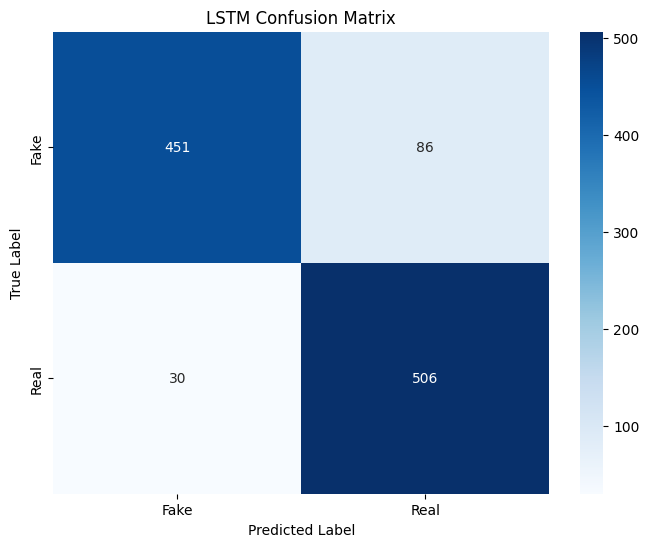

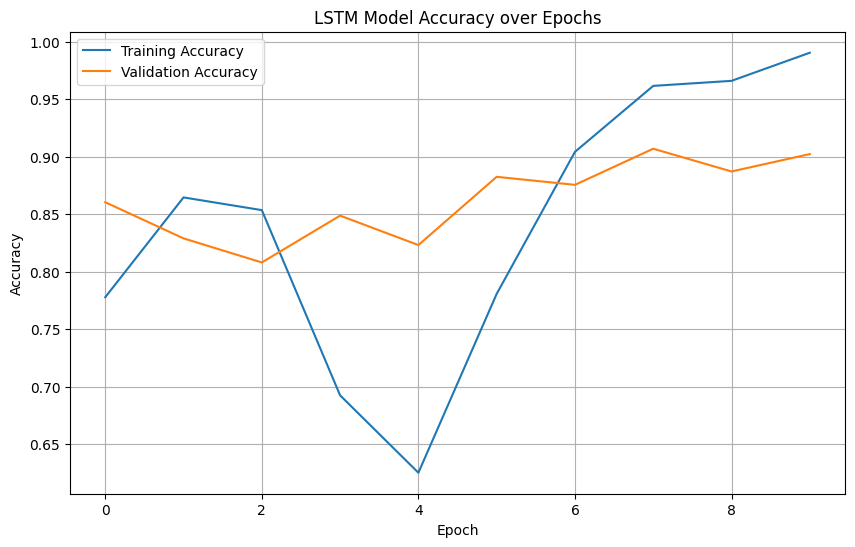

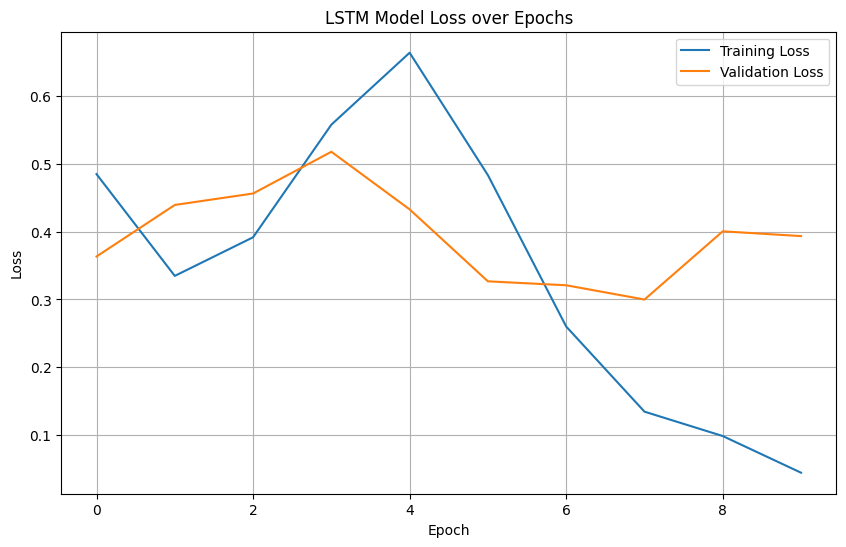

In [ ]:
# prompt: Create a complete Keras LSTM-based fake news detection model for Bangla text in Colab. Use Tokenizer and pad_sequences for text preprocessing, build a Sequential model with Embedding and LSTM layers, and evaluate it using accuracy. Assume the All_df  has 'text' and 'label' columns.

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Assuming All_df is already loaded and contains 'text' and 'Label' columns
# Split data into training and testing sets
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(All_df['text'], All_df['Label'], test_size=0.2, random_state=42, stratify=All_df['Label'])

# Define parameters for text processing
vocab_size = 10000  # Maximum number of words to keep
embedding_dim = 100 # Dimension of the embedding vector
max_len = 128       # Maximum length of sequences

# Initialize Tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# Fit tokenizer on training text data
tokenizer.fit_on_texts(X_train_lstm)

# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train_lstm)
test_sequences = tokenizer.texts_to_sequences(X_test_lstm)

# Pad sequences
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')

# Build the LSTM model
model = Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Use sigmoid for binary classification
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Print model summary
model.summary()

# Train the model
epochs = 10  # You can adjust the number of epochs
batch_size = 32 # You can adjust the batch size

history = model.fit(train_padded, y_train_lstm, epochs=epochs, validation_split=0.2, batch_size=batch_size, verbose=1)

# Evaluate the model on the test set
loss, accuracy = model.evaluate(test_padded, y_test_lstm, verbose=0)
print(f"\nLSTM Model Accuracy: {accuracy}")

# Get predictions
y_pred_lstm_proba = model.predict(test_padded)
y_pred_lstm = (y_pred_lstm_proba > 0.5).astype(int) # Convert probabilities to binary predictions

# Print classification report
print("\nLSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm, target_names=['Fake', 'Real']))

# Plot confusion matrix
conf_matrix_lstm = confusion_matrix(y_test_lstm, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt="d", cmap="Blues", xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("LSTM Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Plot training history (accuracy)
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('LSTM Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Plot training history (loss)
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('LSTM Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# prompt: Generate a complete Colab-compatible pipeline using HuggingFace Transformers to classify Bangla fake news using the model "sagorsarker/bangla-bert-base". The dataset should be a CSV file with columns 'text' and 'label'. Include tokenization, model loading, training using Trainer API, and evaluation using accuracy and classification report.

import numpy as np
!pip install -q transformers datasets accelerate
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, classification_report

# Assuming All_df with 'text' and 'Label' columns is available from previous code
# Create a new DataFrame with just 'text' and 'Label' for the transformer pipeline
df_transformer = All_df[['text', 'Label']].copy()
df_transformer.rename(columns={'Label': 'labels'}, inplace=True) # Rename 'Label' to 'labels'

# Split data into train, validation, and test sets
train_df_transformer, test_df_transformer = train_test_split(df_transformer, test_size=0.2, random_state=42, stratify=df_transformer['labels'])
train_df_transformer, val_df_transformer = train_test_split(train_df_transformer, test_size=0.2, random_state=42, stratify=train_df_transformer['labels']) # Corrected typo here

# Convert pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df_transformer)
val_dataset = Dataset.from_pandas(val_df_transformer)
test_dataset = Dataset.from_pandas(test_df_transformer)

# Load the tokenizer
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128) # Added max_length

# Apply tokenization
tokenized_train_dataset = train_dataset.map(tokenize_function, batched=True)
tokenized_val_dataset = val_dataset.map(tokenize_function, batched=True)
tokenized_test_dataset = test_dataset.map(tokenize_function, batched=True)

# Load the model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2) # Assuming 2 classes: 0 and 1

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=2, # Saves latest 2 checkpoints
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy", # Ensure this matches the output of compute_metrics
)

# Define metrics calculation function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    return {"eval_accuracy": accuracy} # Changed key to match metric_for_best_model

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    compute_metrics=compute_metrics,
)

# Train the model
trainer.train()

# Evaluate the model on the test set
eval_results = trainer.evaluate(tokenized_test_dataset)
print(f"Test Accuracy: {eval_results['eval_accuracy']}")

# Get predictions for classification report
predictions, labels, _ = trainer.predict(tokenized_test_dataset)
predictions = np.argmax(predictions, axis=1)

# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions, target_names=['Fake', 'Real']))

Map:   0%|          | 0/3432 [00:00<?, ? examples/s]

Map:   0%|          | 0/859 [00:00<?, ? examples/s]

Map:   0%|          | 0/1073 [00:00<?, ? examples/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: abidur1098 (abidur1098-bangladesh-university-of-business-and-technology) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Accuracy
1,0.476200,0.326295,0.873108
2,0.225000,0.410590,0.881257
3,0.074200,0.471385,0.901048


Test Accuracy: 0.8825722273998136
Classification Report:
              precision    recall  f1-score   support

        Fake       0.92      0.84      0.88       537
        Real       0.85      0.93      0.89       536

    accuracy                           0.88      1073
   macro avg       0.89      0.88      0.88      1073
weighted avg       0.89      0.88      0.88      1073



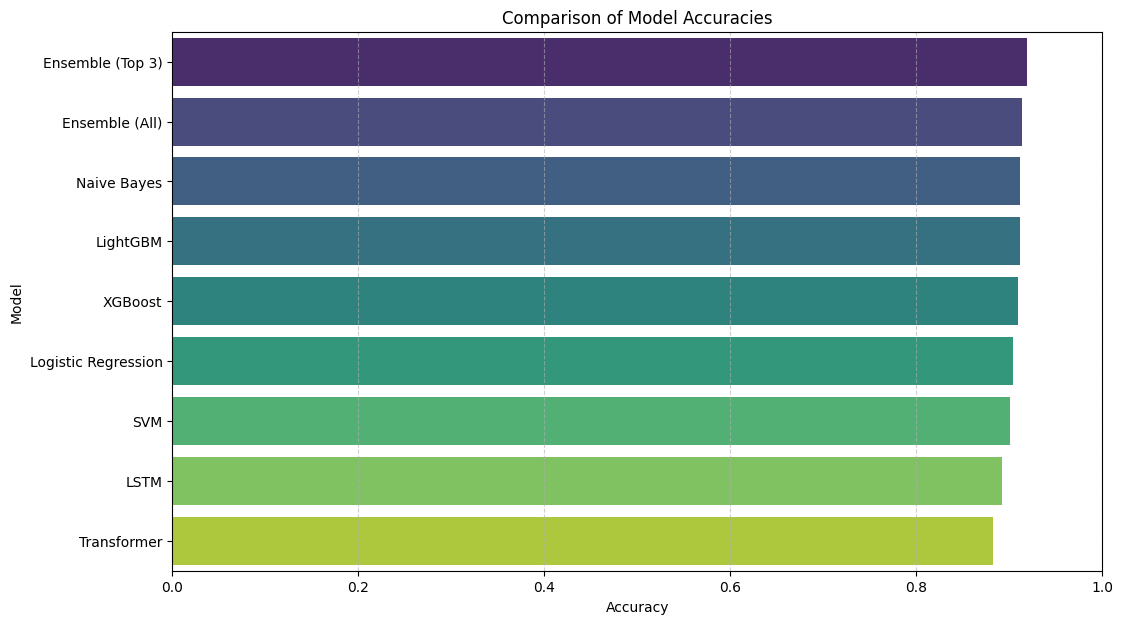

In [ ]:
# prompt: do data vitualization

import matplotlib.pyplot as plt
# Combine the accuracies of all models
model_accuracies = {
    'SVM': accuracy_svm,
    'Logistic Regression': accuracy_log_reg,
    'Naive Bayes': accuracy_nb,
    'XGBoost': accuracy_xgb,
    'LightGBM': accuracy_lgb,
    'Ensemble (All)': accuracy_ensemble,
    'Ensemble (Top 3)': accuracy_ensemble_top3,
    'LSTM': accuracy, # Using 'accuracy' from LSTM evaluation
    'Transformer': eval_results['eval_accuracy'] # Using 'eval_accuracy' from Transformer evaluation
}

# Sort models by accuracy
sorted_models = sorted(model_accuracies.items(), key=lambda item: item[1], reverse=True)

# Extract model names and accuracies
model_names = [item[0] for item in sorted_models]
accuracies = [item[1] for item in sorted_models]

# Create a bar plot
plt.figure(figsize=(12, 7))
sns.barplot(x=accuracies, y=model_names, palette="viridis")
plt.xlabel("Accuracy")
plt.ylabel("Model")
plt.title("Comparison of Model Accuracies")
plt.xlim(0, 1.0) # Set x-axis limit to 0-1 for accuracy
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()